In [65]:
import utils
from jsonl_dump import download_parse_delivered_into_jsonl
from utils import DATA_DIR, service_account_path
LIMIT_ITEMS_TO_FIRST_N = 5 # None for full
BATCH_IDS = [1,2,3,4]
max_workers = 20

In [2]:
delivered4 = download_parse_delivered_into_jsonl(BATCH_IDS, no_work=False)

In [3]:
delivered_df = delivered4['delivered_df']
conversations = delivered4['conversations']

In [66]:
from importlib import reload
import use_case
reload(use_case)
from use_case import get_use_case_data_batch_conversations
import areas_of_focus
reload(areas_of_focus)
from areas_of_focus import get_areas_of_focus_data_batch_conversations
import behaviour_tagging
reload(behaviour_tagging)
from behaviour_tagging import get_behavioural_tags_data_batch_conversations
import domain_classification
reload(domain_classification)
from domain_classification import get_domain_data_batch_conversations
import programming_language_tagging
reload(programming_language_tagging)
from programming_language_tagging import get_programming_language_data_batch_conversations
import dependency_classification
reload(dependency_classification)
from dependency_classification import get_dependency_data_batch_conversations

In [67]:
from utils import DATA_DIR
import os
import pickle
from datetime import datetime

batch_folder_prefix = DATA_DIR + 'jsonl_conversations/batch_'
progress_backup_folder = DATA_DIR + 'progress_backup/'
current_date = datetime.now().strftime('%Y-%m-%d__%H-%M-%S')

analytics_functions = {
    'behavioural_tags': get_behavioural_tags_data_batch_conversations,
    'use_case_data': get_use_case_data_batch_conversations,
    'areas_of_focus_data': get_areas_of_focus_data_batch_conversations,
    'domain_data': get_domain_data_batch_conversations,
    'programming_language_data': get_programming_language_data_batch_conversations,
    'dependency_data': get_dependency_data_batch_conversations,
}
batch_results = {}

number_of_batches_total = len(BATCH_IDS)
for i in range(1, 1 + number_of_batches_total):
    print('='*60)
    print(f"Processing batch {i} of {number_of_batches_total}")
    batch_folder = batch_folder_prefix + str(i)
    batch_results[i] = {}
    
    for analytics_type, analytics_function in analytics_functions.items():
        analytics_remaining = len(analytics_functions) - list(analytics_functions.keys()).index(analytics_type)
        print(f"  Generating {analytics_type.replace('_', ' ')}... ({analytics_remaining}/{len(analytics_functions)} analytics for this batch)")
        print('-'*5)
        batch_results[i][analytics_type] = analytics_function(
            batch_folder, max_workers=max_workers, limit_items_to_first_n=LIMIT_ITEMS_TO_FIRST_N
        )
        # Save progress after each item
        progress_backup_path = os.path.join(progress_backup_folder, f'{current_date}.pkl')
        os.makedirs(os.path.dirname(progress_backup_path), exist_ok=True)
        with open(progress_backup_path, 'wb') as backup_file:
            pickle.dump(batch_results, backup_file)

print('='*60)
print('DONE.')
print('='*60)

Processing batch 1 of 4
  Generating behavioural tags...


Processing Conversations:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Conversations: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


  Generating use case data...


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


  Generating areas of focus data...


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


  Generating domain data...


Processing Conversations: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


  Generating programming language data...


Processing Conversations: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


  Generating dependency data...


Processing Conversations:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Expected tool_calls in ai_message.additional_kwargs, but none found.


Processing Conversations:  80%|████████  | 4/5 [00:03<00:00,  1.50it/s]

Expected tool_calls in ai_message.additional_kwargs, but none found.


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Expected tool_calls in ai_message.additional_kwargs, but none found.
Processing batch 2 of 4
  Generating behavioural tags...


Processing Conversations: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


  Generating use case data...


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


  Generating areas of focus data...


Processing Conversations: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


  Generating domain data...


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


  Generating programming language data...


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


  Generating dependency data...


Processing Conversations:  80%|████████  | 4/5 [00:03<00:00,  1.32it/s]

Expected tool_calls in ai_message.additional_kwargs, but none found.


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Expected tool_calls in ai_message.additional_kwargs, but none found.
Processing batch 3 of 4
  Generating behavioural tags...


Processing Conversations: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


  Generating use case data...


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


  Generating areas of focus data...


Processing Conversations: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


  Generating domain data...


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


  Generating programming language data...


Processing Conversations: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


  Generating dependency data...


Processing Conversations:  20%|██        | 1/5 [00:02<00:10,  2.72s/it]

Expected tool_calls in ai_message.additional_kwargs, but none found.


Processing Conversations: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Processing batch 4 of 4
  Generating behavioural tags...


Processing Conversations: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


  Generating use case data...


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


  Generating areas of focus data...


Processing Conversations: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


  Generating domain data...


Processing Conversations: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


  Generating programming language data...


Processing Conversations: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


  Generating dependency data...


Processing Conversations:  60%|██████    | 3/5 [00:03<00:02,  1.26s/it]

Expected tool_calls in ai_message.additional_kwargs, but none found.


Processing Conversations: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

DONE.


In [80]:
import pandas as pd

# Function to flatten the batch_results into a list of dictionaries
def flatten_batch_results(batch_results):
    flattened_data = []
    for batch_id, analytics_types in batch_results.items():
        for analytics_type, analytics_items in analytics_types.items():
            for item in analytics_items:
                item_data = {
                    'batch_id': batch_id,
                    'colab_link': item['colab_link'],
                    analytics_type: {k: v for k, v in item.items() if k not in ['colab_link', 'id']}
                }
                flattened_data.append(item_data)
    return flattened_data

# Flatten the batch_results
flattened_data = flatten_batch_results(batch_results)

# Create a dataframe from the flattened data
batch_results_df = pd.DataFrame(flattened_data)

# Function to extend the delivered_df with analytics data
def extend_delivered_df(delivered_df, batch_results_df):
    for analytics_type in analytics_functions.keys():
        analytics_df = batch_results_df[['batch_id', 'colab_link', analytics_type]].dropna()
        # Merge on 'colab_link' and exclude 'batch_id' and 'colab_link' from the right dataframe
        merged_df = delivered_df.merge(analytics_df, left_on='task_link', right_on='colab_link', how='left', suffixes=('', '_right'))
        # Drop the '_right' columns after merging
        for col in ['batch_id_right', 'colab_link_right']:
            if col in merged_df.columns:
                merged_df.drop(columns=[col], inplace=True)
        delivered_df = merged_df
    return delivered_df

# Extend the delivered_df with the batch_results_df
extended_delivered_df = extend_delivered_df(delivered_df, batch_results_df)

# Filter the extended dataframe to show only rows with non-null analytics data
filtered_extended_delivered_df = extended_delivered_df[
    extended_delivered_df.filter(like='_data').notnull().any(axis=1)
]

filtered_extended_delivered_df


,task_link,jsonl_link,metadata__topic,number_of_turns,duration_mins,batch_id,colab_link,behavioural_tags,use_case_data,areas_of_focus_data,domain_data,programming_language_data,dependency_data
33,https://colab.research.google.com/drive/1Iz1hQ...,https://drive.google.com/file/d/1dp99pw8zVR327...,algorithms > by_topic > bit_manipulation,1,10,1,https://colab.research.google.com/drive/1Iz1hQ...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'Basic scripting', 'sub_level': ...","{'top_level': 'Problem Solving', 'sub_level': ...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': []}
223,https://colab.research.google.com/drive/1h1rav...,https://drive.google.com/file/d/1E_2cCdearNcfA...,python_language_and_scripting > memory_managem...,1,10,1,https://colab.research.google.com/drive/1h1rav...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'General coding help', 'sub_leve...","{'top_level': 'Python Basics & Scripting', 'su...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': [{'dependency': 'vanil...
231,https://colab.research.google.com/drive/1hTG6I...,https://drive.google.com/file/d/1NloPbJ2VooS9H...,algorithms > by_data_structure > trees,1,10,1,https://colab.research.google.com/drive/1hTG6I...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'Basic scripting', 'sub_level': ...","{'top_level': 'Python Basics & Scripting', 'su...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': [{'dependency': 'vanil...
246,https://colab.research.google.com/drive/1ixtti...,https://drive.google.com/file/d/13CrYrLbgemfg2...,algorithms > by_topic > counting,1,12,1,https://colab.research.google.com/drive/1ixtti...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'Basic scripting', 'sub_level': ...","{'top_level': 'Python Basics & Scripting', 'su...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': []}
288,https://colab.research.google.com/drive/1lZQ_X...,https://drive.google.com/file/d/1HfgGWZbstBqGM...,algorithms > by_topic > backtracking,1,15,1,https://colab.research.google.com/drive/1lZQ_X...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'Basic scripting', 'sub_level': ...","{'top_level': 'Python Basics & Scripting', 'su...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': []}
310,https://colab.research.google.com/drive/1Jb9p7...,https://drive.google.com/file/d/13ETXOdXU1gnk8...,algorithms > by_topic > path_finding,3,50,2,https://colab.research.google.com/drive/1Jb9p7...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'General coding help', 'sub_leve...","{'top_level': 'Problem Solving', 'sub_level': ...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': []}
532,https://colab.research.google.com/drive/1YW-M2...,https://drive.google.com/file/d/1MVsHt6ALfw348...,unit_testing_methodology > data_quality_tests,1,20,2,https://colab.research.google.com/drive/1YW-M2...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'Write unit test', 'sub_level': ...","{'top_level': 'Testing', 'sub_level': 'Softwar...","{'language_presence': [{'language': 'Python', ...",{'dependency_presence': [{'dependency': 'unitt...
540,https://colab.research.google.com/drive/1-MuAA...,https://drive.google.com/file/d/1kHGS8clpWl3h9...,algorithms > by_topic > statistics,2,20,2,https://colab.research.google.com/drive/1-MuAA...,{'behaviours': [{'top_level': 'Continuation Fo...,{'summary': 'The user is utilizing the Assista...,"{'top_level': 'Basic scripting', 'sub_level': .

In [88]:
filtered_extended_delivered_df.columns

Index(['task_link', 'jsonl_link', 'metadata__topic', 'number_of_turns',
       'duration_mins', 'batch_id', 'colab_link', 'behavioural_tags',
       'use_case_data', 'areas_of_focus_data', 'domain_data',
       'programming_language_data', 'dependency_data'],
      dtype='object')

In [111]:
expanded_enriched_df = filtered_extended_delivered_df.copy()


def expand_dependency_data(row):
    dependency_presence = row['dependency_data'].get('dependency_presence', [])
    task_link = row['task_link']
    return [{'task_link': task_link, 'dependency': dep['dependency'].lower(), 'percentage': dep['percentage']} for dep in dependency_presence]

dependency_data = expanded_enriched_df.apply(expand_dependency_data, axis=1).explode()
dependency_data = pd.DataFrame(dependency_data[~dependency_data.isna()].tolist())
dependency_data = dependency_data.dropna().reset_index(drop=True)
dependency_data

,task_link,dependency,percentage
0,https://colab.research.google.com/drive/1h1rav...,vanilla python,1.00
1,https://colab.research.google.com/drive/1hTG6I...,vanilla python,1.00
2,https://colab.research.google.com/drive/1YW-M2...,unittest,0.50
3,https://colab.research.google.com/drive/1-MuAA...,vanilla python,1.00
4,https://colab.research.google.com/drive/1xepiQ...,pandas,1.00
5,https://colab.research.google.com/drive/1ZjvRQ...,flask,0.90
6,https://colab.research.google.com/drive/1ZjvRQ...,vanilla python,0.10
7,https://colab.research.google.com/drive/1J4k32...,datetime,0.50
8,https://colab.research.google.com/drive/1J4k32...,vanilla python,0.50
9,https://colab.research.google.com/drive/1dpcio...,beautifulsoup,0.70


In [133]:

def extract_summary(data):
    return data.get('summary', '') if pd.notnull(data) else ''


expanded_enriched_df = filtered_extended_delivered_df.copy()
expanded_enriched_df.drop(columns=['colab_link', 'jsonl_link'], inplace=True)



def expand_language_data(row):
    language_presence = row['programming_language_data'].get('language_presence', [])
    task_link = row['task_link']
    return [{'task_link': task_link, 'tag': lang['language'].lower(), 'percentage': lang['percentage']} for lang in language_presence]

programming_language_data = expanded_enriched_df.apply(expand_language_data, axis=1).explode()
programming_language_data = pd.DataFrame(programming_language_data[~programming_language_data.isna()].tolist())


expanded_enriched_df.drop(columns=['programming_language_data'], inplace=True)

def expand_dependency_data(row):
    dependency_presence = row['dependency_data'].get('dependency_presence', [])
    task_link = row['task_link']
    return [{'task_link': task_link, 'tag': dep['dependency'].lower(), 'percentage': dep['percentage']} for dep in dependency_presence]

dependency_data = expanded_enriched_df.apply(expand_dependency_data, axis=1).explode()
dependency_data = pd.DataFrame(dependency_data[~dependency_data.isna()].tolist())


expanded_enriched_df.drop(columns=['dependency_data'], inplace=True)



expanded_enriched_df['use_case__summary'] = expanded_enriched_df['use_case_data'].map(extract_summary)

def expand_tags(row):
    tags = row['use_case_data'].get('tags', [])
    task_link = row['task_link']
    return [{'task_link': task_link, 'tag': tag.lower()} for tag in tags]

use_case_tags_data = expanded_enriched_df.apply(expand_tags, axis=1).explode()
use_case_tags_data = pd.DataFrame(use_case_tags_data[~use_case_tags_data.isna()].tolist())

expanded_enriched_df.drop(columns=['use_case_data'], inplace=True)

def extract_area_of_focus(data):
    if pd.notnull(data):
        return {
            'area_of_focus__top_level': data.get('top_level', '').lower(),
            'area_of_focus__sub_level': data.get('sub_level', '').lower(),
            'area_of_focus__detailed_level': data.get('detailed_level', '').lower(),
            #'area_of_focus_custom_category': data.get('new_filled_category', False)
        }
    else:
        return {
            'area_of_focus__top_level': '',
            'area_of_focus__sub_level': '',
            'area_of_focus__detailed_level': '',
            #'area_of_focus_custom_category': False
        }

areas_of_focus_columns = expanded_enriched_df['areas_of_focus_data'].map(extract_area_of_focus).apply(pd.Series)
expanded_enriched_df = pd.concat([expanded_enriched_df, areas_of_focus_columns], axis=1)
expanded_enriched_df.drop(columns=['areas_of_focus_data'], inplace=True)

def expand_domain_data(domain_data):
    if pd.notnull(domain_data):
        return {
            'domain__top_level': domain_data.get('top_level', '').lower(),
            'domain__sub_level': domain_data.get('sub_level', '').lower(),
            'domain__detailed_level': domain_data.get('detailed_level', '').lower()
        }
    else:
        return {
            'domain__top_level': '',
            'domain__sub_level': '',
            'domain__detailed_level': ''
        }

domain_data_columns = expanded_enriched_df['domain_data'].map(expand_domain_data).apply(pd.Series)
expanded_enriched_df = pd.concat([expanded_enriched_df, domain_data_columns], axis=1)
expanded_enriched_df.drop(columns=['domain_data'], inplace=True)


def extract_behavioural_tags(row):
    data = row['behavioural_tags']
    if pd.notnull(data) and 'behaviours' in data:
        tags = data['behaviours']
        return [
            {
                'task_link': row['task_link'],
                'top_level': tag.get('top_level', '').lower(),
                'sub_level': tag.get('sub_level', '').lower(),
                'custom_category': tag.get('new_filled_category', False)
            }
            for tag in tags
        ]
    return []

behavioural_tags_data = expanded_enriched_df.apply(extract_behavioural_tags, axis=1).explode()
behavioural_tags_data = pd.DataFrame(behavioural_tags_data[~behavioural_tags_data.isna()].tolist())


expanded_enriched_df.drop(columns=['behavioural_tags'], inplace=True)
#cols = list(expanded_enriched_df.columns)
#cols.append(cols.pop(cols.index('area_of_focus_custom_category')))
#expanded_enriched_df = expanded_enriched_df[cols]




import os

def save_to_csv(df, dir_name, suffix):
    filename = f'{base_filename}-{suffix}.csv'
    path = os.path.join(dir_name, filename)
    df.to_csv(path)

base_filename = f'batches{".".join(map(str, BATCH_IDS))}_'
base_filename += f'{"full" if LIMIT_ITEMS_TO_FIRST_N is None else str(LIMIT_ITEMS_TO_FIRST_N) + "items"}'
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
bundle_dir = f'{DATA_DIR}/{base_filename}_{timestamp}'
os.makedirs(bundle_dir, exist_ok=True)

save_to_csv(expanded_enriched_df, bundle_dir, 'expanded_enriched_df')
save_to_csv(use_case_tags_data, bundle_dir, 'use_case_tags')
save_to_csv(behavioural_tags_data, bundle_dir, 'behavioural_tags')
save_to_csv(programming_language_data, bundle_dir, 'programming_language_tags')
save_to_csv(dependency_data, bundle_dir, 'dependency_tags')

In [127]:
expanded_enriched_df.head(5)

,task_link,metadata__topic,number_of_turns,duration_mins,batch_id,use_case__summary,area_of_focus__top_level,area_of_focus__sub_level,area_of_focus__detailed_level,domain__top_level,domain__sub_level,domain__detailed_level
33,https://colab.research.google.com/drive/1Iz1hQ...,algorithms > by_topic > bit_manipulation,1,10,1,The user is utilizing the Assistant to underst...,basic scripting,write simple code in python,bit manipulation,problem solving,algorithms,bit manipulation
223,https://colab.research.google.com/drive/1h1rav...,python_language_and_scripting > memory_managem...,1,10,1,The user is utilizing the Assistant to solve a...,general coding help,refactor code,manage memory resources,python basics & scripting,memory management,garbage collection
231,https://colab.research.google.com/drive/1hTG6I...,algorithms > by_data_structure > trees,1,10,1,The user is utilizing the Assistant to underst...,basic scripting,write simple code in python,merge binary trees,python basics & scripting,data structures,binary trees
246,https://colab.research.google.com/drive/1ixtti...,algorithms > by_topic > counting,1,12,1,The user is utilizing the Assistant to learn h...,basic scripting,write simple code in python,word count function,python basics & scripting,programming concepts,functions and data structures
288,https://colab.research.google.com/drive/1lZQ_X...,algorithms > by_topic > backtracking,1,15,1,The user is utilizing the Assistant to modify ...,basic scripting,write simple code in python,modify existing code,python basics & scripting,python functions,function modification


In [128]:
use_case_tags_data.head(5)

,task_link,tag
0,https://colab.research.google.com/drive/1Iz1hQ...,programming
1,https://colab.research.google.com/drive/1Iz1hQ...,python
2,https://colab.research.google.com/drive/1Iz1hQ...,bit manipulation
3,https://colab.research.google.com/drive/1Iz1hQ...,learning
4,https://colab.research.google.com/drive/1Iz1hQ...,code example


In [129]:
behavioural_tags_data.head(5)

,task_link,top_level,sub_level,custom_category
0,https://colab.research.google.com/drive/1Iz1hQ...,continuation follow up,incrementally build,False
1,https://colab.research.google.com/drive/1Iz1hQ...,respond to assistant,answer a question,False
2,https://colab.research.google.com/drive/1h1rav...,continuation follow up,supplement/extend,False
3,https://colab.research.google.com/drive/1h1rav...,respond to assistant,answer a question,False
4,https://colab.research.google.com/drive/1hTG6I...,continuation follow up,incrementally build,False


In [130]:
programming_language_data.head(5)

,task_link,language,percentage
0,https://colab.research.google.com/drive/1Iz1hQ...,python,1.0
1,https://colab.research.google.com/drive/1h1rav...,python,1.0
2,https://colab.research.google.com/drive/1hTG6I...,python,1.0
3,https://colab.research.google.com/drive/1ixtti...,python,1.0
4,https://colab.research.google.com/drive/1lZQ_X...,python,1.0


In [131]:
dependency_data.head(5)

,task_link,dependency,percentage
0,https://colab.research.google.com/drive/1h1rav...,vanilla python,1.0
1,https://colab.research.google.com/drive/1hTG6I...,vanilla python,1.0
2,https://colab.research.google.com/drive/1YW-M2...,unittest,0.5
3,https://colab.research.google.com/drive/1-MuAA...,vanilla python,1.0
4,https://colab.research.google.com/drive/1xepiQ...,pandas,1.0


In [121]:

import gspread
from gspread_dataframe import set_with_dataframe

from utils import service_account_path

PROD_OUTPUT_SHEET_URL = "https://docs.google.com/spreadsheets/d/1wUWll720oz6Rnc4YKHeWFWbZbTMWbda2rfVh8jPLU2g"

def set_sheet_with_df(sheet_url, sheet_name, df):
    gc = gspread.service_account(filename=service_account_path)
    sh = gc.open_by_url(sheet_url)
    try:
        worksheet = sh.worksheet(sheet_name)
    except gspread.WorksheetNotFound:
        worksheet = sh.add_worksheet(title=sheet_name, rows=1, cols=1)

    set_with_dataframe(worksheet, df)

In [134]:
sheet_names_and_dataframes = [
    ('Expanded Enriched Data', expanded_enriched_df),
    ('Use Case Tags', use_case_tags_data),
    ('Behavioural Tags', behavioural_tags_data),
    ('Programming Language Tags', programming_language_data),
    ('Dependency Tags', dependency_data)
]

for sheet_name, dataframe in sheet_names_and_dataframes:
    print(f"Updating sheet: {sheet_name}")
    set_sheet_with_df(PROD_OUTPUT_SHEET_URL, sheet_name, dataframe)
    print(f"Sheet {sheet_name} updated successfully.")
    print('-'*60)


Updating sheet: Expanded Enriched Data
Sheet Expanded Enriched Data updated successfully.
------------------------------------------------------------
Updating sheet: Use Case Tags
Sheet Use Case Tags updated successfully.
------------------------------------------------------------
Updating sheet: Behavioural Tags
Sheet Behavioural Tags updated successfully.
------------------------------------------------------------
Updating sheet: Programming Language Tags
Sheet Programming Language Tags updated successfully.
------------------------------------------------------------
Updating sheet: Dependency Tags
Sheet Dependency Tags updated successfully.
------------------------------------------------------------


In [20]:
behavioural_tags_data.columns

Index(['task_link', 'top_level', 'sub_level', 'custom_category'], dtype='object')

In [33]:
import pandas as pd
import plotly.express as px
from operations.delivery.split_analytics.utils import turing_palette


turing_palette = [
    "#326FDC",  # Celtic Blue
    "#47ABFD",  # Argentinian Blue
    "#959595",  # Battleship gray
    "#FFFFFF",  # White
    "#EFEFEF",  # Anti-flash white
    "#000000",  # Black
]

df = behavioural_tags_data
fig = px.treemap(
    df, 
    path=['top_level', 'sub_level'], 
    title="Hierarchical Domain Classification",
    height=800,
    width=1200,
    color_discrete_sequence=turing_palette
)
fig.update_layout(
    margin=dict(t=100, l=50, r=50, b=50),
    title_font=dict(size=24),
    font=dict(size=18, family='Courier New, monospace')
)
fig.show()

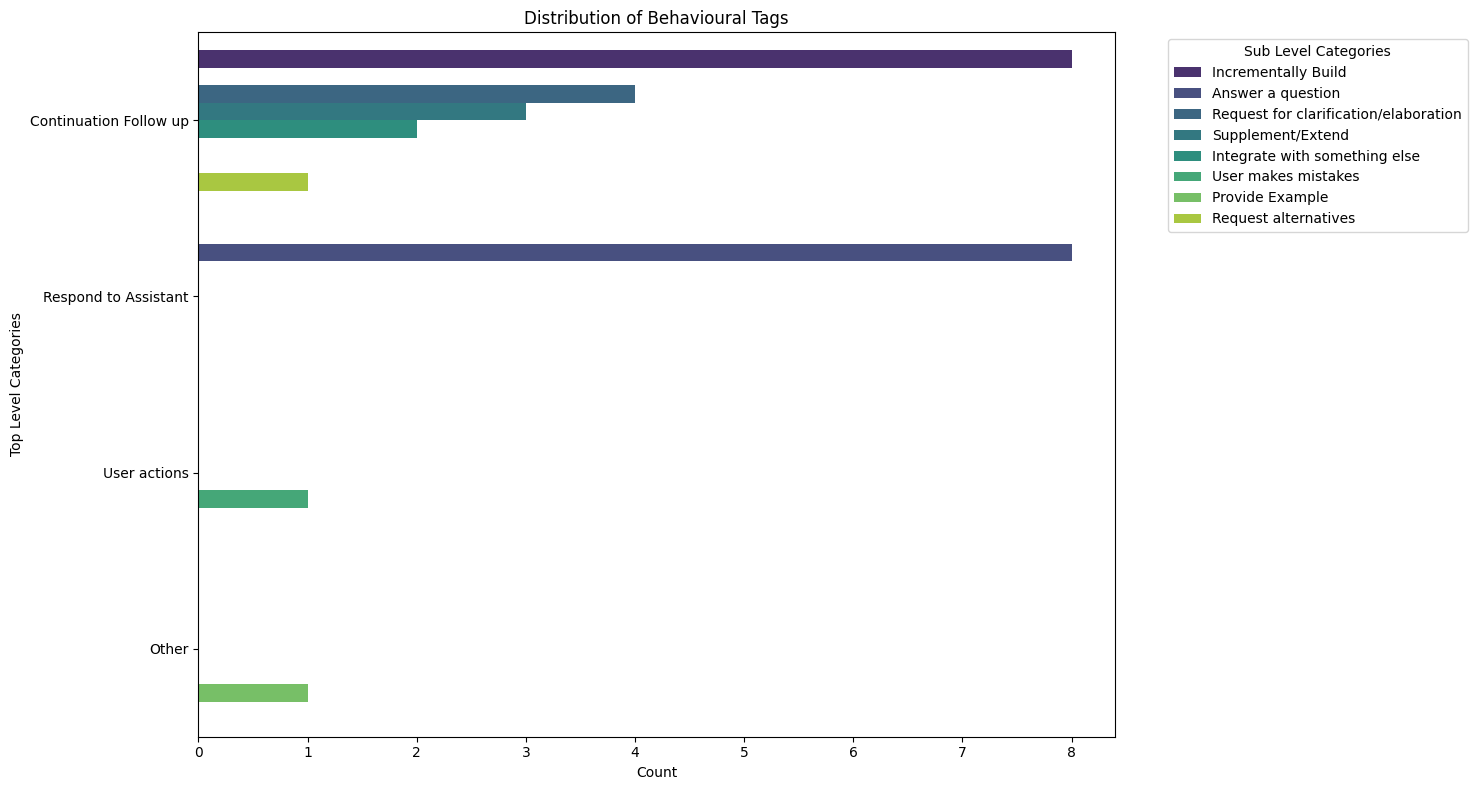

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot hierarchical data of behavioural_tags_data
def plot_hierarchical_data(df):
    plt.figure(figsize=(15, 8))
    sns.countplot(data=df, y='top_level', hue='sub_level', palette='viridis')
    plt.title('Distribution of Behavioural Tags')
    plt.xlabel('Count')
    plt.ylabel('Top Level Categories')
    plt.legend(title='Sub Level Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_hierarchical_data(behavioural_tags_data)


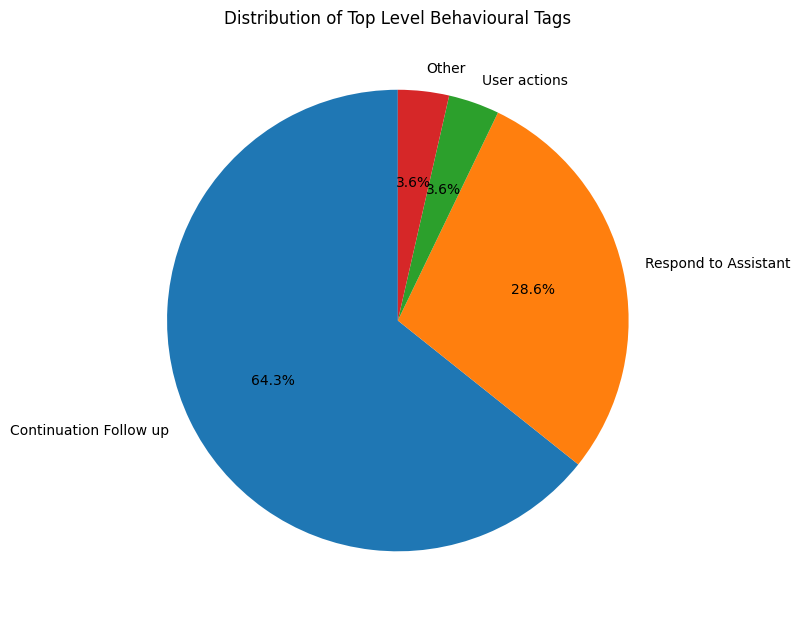

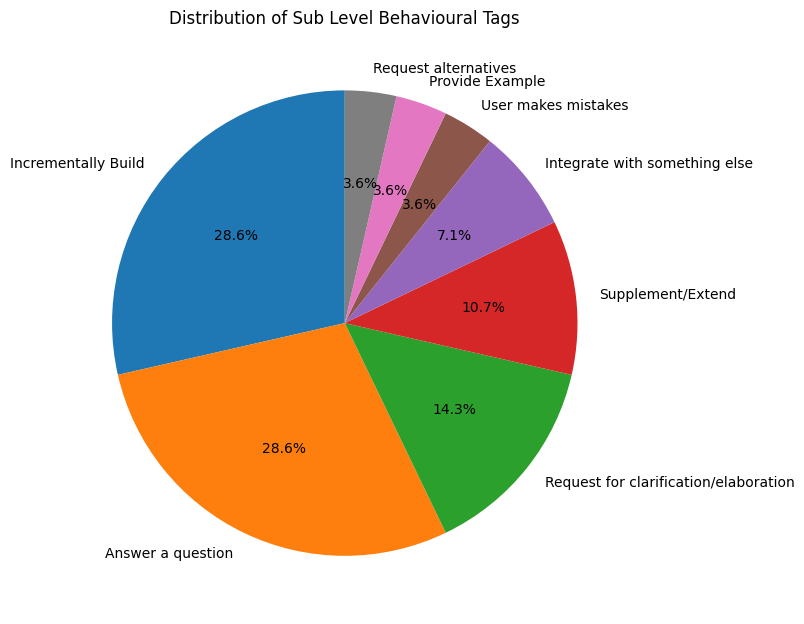

In [19]:
import matplotlib.pyplot as plt

# Plot pie chart for top level categories of behavioural_tags_data
def plot_pie_chart(df, column, title):
    plt.figure(figsize=(8, 8))
    df[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.ylabel('')  # Hide the y-label
    plt.tight_layout()
    plt.show()

# Plot pie charts for top level and sub level categories
plot_pie_chart(behavioural_tags_data, 'top_level', 'Distribution of Top Level Behavioural Tags')
plot_pie_chart(behavioural_tags_data, 'sub_level', 'Distribution of Sub Level Behavioural Tags')


In [31]:
print(filtered_extended_delivered_df['use_case_data'].iloc[0])
print(filtered_extended_delivered_df['areas_of_focus_data'].iloc[0])
print(filtered_extended_delivered_df['behavioural_tags'].iloc[0])


{'summary': "The user is utilizing the Assistant to improve a programming function that reverses strings while maintaining the position of special characters. The user seeks guidance on modifying the code to achieve this functionality and engages in a collaborative coding session with the Assistant. The conversation involves sharing code snippets, discussing potential solutions, and refining the function to meet the specified requirements. The user's use case demonstrates a practical application of the Assistant's capabilities in software development and problem-solving.", 'tags': ['software development', 'coding assistance', 'problem-solving', 'code refinement', 'collaborative programming']}
{'top_level': 'General coding help', 'sub_level': 'Explain complex code snippets', 'detailed_level': 'Modifying a function to handle special cases', 'new_filled_category': False}
{'behaviours': [{'top_level': 'Continuation Follow up', 'sub_level': 'Incrementally Build', 'detailed_level': "User inc

In [19]:
delivered4 = download_parse_delivered_into_jsonl([1,2,3,4], no_work=True)
delivered_df = delivered4['delivered_df']
conversations = delivered4['conversations']

In [20]:
data = [
    # User Behaviors
    ("User", "Emotional Response", "Confusion"),
    ("User", "Emotional Response", "Frustration"),
    ("User", "Behavior", "Self-Contradiction"),
    ("User", "Behavior", "Error Identification"),
    ("User", "Behavior", "Making Errors"),
    ("User", "Feedback", "Satisfaction Expression"),
    ("User", "Feedback", "Compliment Offering"),
    ("User", "Intent", "Information Seeking"),
    ("User", "Intent", "Transactional"),
    ("User", "Intent", "Casual Interaction"),
    ("User", "Conversation Progression", "Building Upon Discussion"),
    ("User", "Conversation Progression", "Extending Scope"),
    ("User", "Conversation Progression", "Seeking Clarification"),
    ("User", "Conversation Progression", "Exploring Alternatives"),
    ("User", "Conversation Direction", "Topic Shift"),
    ("User", "Conversation Direction", "Goal Reassessment"),
    
    # Assistant Behaviors
    ("Assistant", "Interaction", "Providing Information"),
    ("Assistant", "Interaction", "Concluding Interaction"),
    ("Assistant", "Interaction", "Resolving Ambiguities"),
    ("Assistant", "Performance", "Misunderstanding"),
    ("Assistant", "Performance", "Accurate Information"),
    ("Assistant", "Performance", "Issue Escalation"),
    ("Assistant", "Technical Support", "Issue Identification"),
    ("Assistant", "Technical Support", "Support Provision"),
    
    # Conversation Closure
    ("General", "Conversation Closure", "Satisfied Conclusion"),
    ("General", "Conversation Closure", "Unsatisfied Conclusion"),
    ("General", "Conversation Closure", "Inactive Termination"),
    
    # Other categories can be added under "General" or other relevant top-level categories
]


import pandas as pd

behavioural_tags_df2 = pd.DataFrame(data, columns=["Top_Level_Category", "Sub_Level_Category", "Detailed_Level_Category"])
behavioural_tags_df2






,Top_Level_Category,Sub_Level_Category,Detailed_Level_Category
0,User,Emotional Response,Confusion
1,User,Emotional Response,Frustration
2,User,Behavior,Self-Contradiction
3,User,Behavior,Error Identification
4,User,Behavior,Making Errors
5,User,Feedback,Satisfaction Expression
6,User,Feedback,Compliment Offering
7,User,Intent,Information Seeking
8,User,Intent,Transactional
9,User,Intent,Casual Interaction
